In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

# import numpyro
# numpyro.set_host_device_count(8)

import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from corner import corner

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

In [5]:
def r2cz(r, H0):
    return r * H0

def r2mu(r):
    return 5 * jnp.log10(r) + 25

In [6]:
def make_mock(Rmax, H0, sigma_v, e_mu, npoints, seed=42, ):
    gen = np.random.default_rng(seed)

    r_true = Rmax * gen.uniform(0, 1, npoints)**(1/3)

    mu = gen.normal(r2mu(r_true), e_mu, )
    cz = gen.normal(r2cz(r_true, H0=H0), sigma_v, )

    return mu, cz


In [25]:
mock_kwargs = dict(Rmax=100, H0=75, sigma_v=300, e_mu=0.1, k=2)


mu, cz = make_mock(**mock_kwargs, npoints=100)

print(f"Mock with {mu.size} points created.")

plt.figure()
plt.hist(mu, bins=30, density=True, )
plt.xlabel("Distance modulus")
plt.show()

plt.figure()
plt.hist(cz, bins=30, density=True, )
plt.xlabel("Observed redshift (z)")
plt.show()


TypeError: make_mock() got an unexpected keyword argument 'k'

In [ ]:
def model(mu, cz, e_mu, Rmax, sigma_v):
    H0 = sample("H0", Uniform(0.1, 200))

    k = sample("k", Uniform(-1, 30))
    log_norm = jnp.log(1 + k) - (1 + k) * jnp.log(Rmax)

    with plate("points", len(mu)):
        r = sample("r_true", Uniform(0, Rmax))
        factor("lp_prior", k * jnp.log(r) + log_norm)

        sample("r_obs", Normal(r2mu(r), e_mu), obs=mu)
        sample("cz_obs", Normal(r2cz(r, H0=H0), sigma_v), obs=cz)


In [21]:
num_warmup = 250
num_samples = 500
num_chains = 1
nrepeat = 1
progress_bar = nrepeat == 1

npoints = 500

biases_H0 = []

for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    mu, cz = make_mock(**mock_kwargs, npoints=npoints, seed=42 + i)
    kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples,
                num_chains=num_chains, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        mu=jnp.asarray(mu),
        cz=jnp.asarray(cz),
        e_mu=mock_kwargs["e_mu"],
        Rmax=mock_kwargs["Rmax"],
        sigma_v=mock_kwargs["sigma_v"],
    )
    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()

    # Compute the bias for this run
    biases_H0.append((np.mean(samples["H0"], axis=0) - mock_kwargs["H0"]) / np.std(samples["H0"], axis=0))

biases_H0 = np.asarray(biases_H0)


sample: 100%|██████████| 750/750 [00:01<00:00, 479.58it/s, 31 steps of size 1.71e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         H0     75.13      0.23     75.13     74.79     75.52    421.38      1.00
          k      2.02      0.14      2.01      1.78      2.23   1170.76      1.00
  r_true[0]     91.53      3.04     91.50     86.30     96.34    591.72      1.00
  r_true[1]     76.68      2.48     76.59     72.33     80.49   1061.90      1.00
  r_true[2]     96.36      2.12     96.49     93.53     99.77    773.07      1.00
  r_true[3]     89.45      2.94     89.23     84.98     94.39    811.80      1.00
  r_true[4]     46.06      1.81     46.08     43.41     49.32   1090.33      1.00
  r_true[5]     94.43      2.55     94.65     90.00     98.32    453.18      1.00
  r_true[6]     92.78      2.66     92.85     88.15     96.75    400.36      1.00
  r_true[7]     90.25      2.74     90.18     85.51     94.40    667.62      1.00
  r_true[8]     51.32      1.81     51.21     48.29     54.64   1587.54      1.00
  r_true[9]    

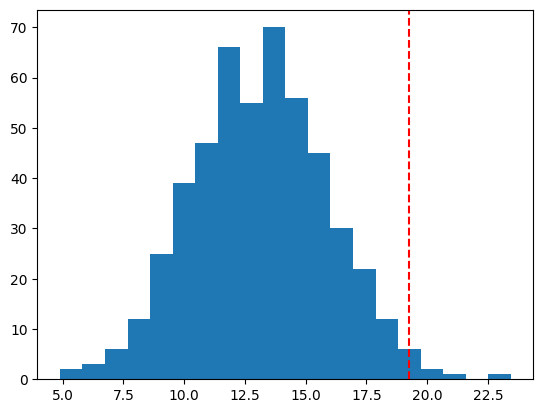

In [25]:
k = 30

plt.figure()
plt.hist(samples["r_true"][:, k], bins="auto")
plt.axvline(r_obs[k], color="red", linestyle="--", label="Observed")

plt.show()

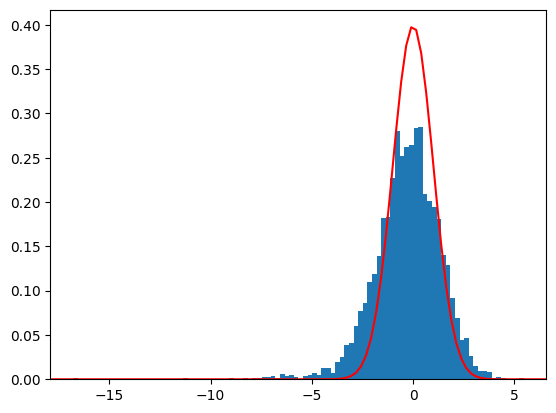

In [26]:
from scipy.stats import norm

plt.figure()
plt.hist(biases_dist.flatten(), bins="auto", density=1)

xlim = plt.xlim()
xrange = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xrange, norm.pdf(xrange, 0, 1), color="red", label="Standard Normal")

plt.xlim(*xlim)

# plt.xlim(-1, 1)

plt.show()


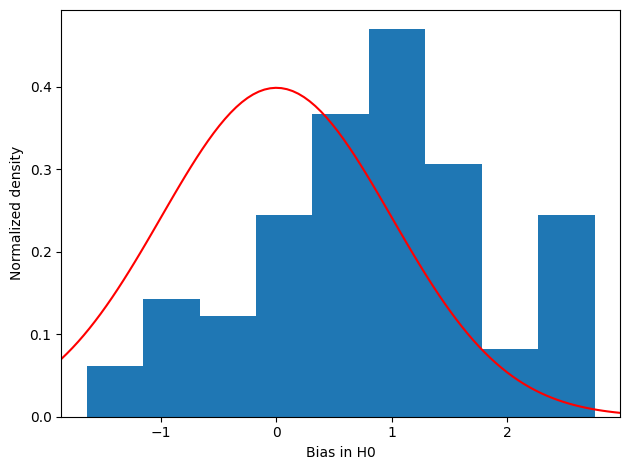

In [28]:
from scipy.stats import norm

plt.figure()
plt.hist(biases_H0.flatten(), bins="auto", density=1)

xlim = plt.xlim()
xrange = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xrange, norm.pdf(xrange, 0, 1), color="red", label="Standard Normal")

plt.xlim(*xlim)
plt.xlabel("Bias in H0")
plt.ylabel("Normalized density")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/biases_H0.png", dpi=450)

# plt.xlim(-1, 1)

plt.show()

In [ ]:
keys = ["H0", "k"]

X = np.vstack([samples[key] for key in keys]).T
truths = np.array([mock_kwargs[key] for key in keys])



/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_46583/443564266.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


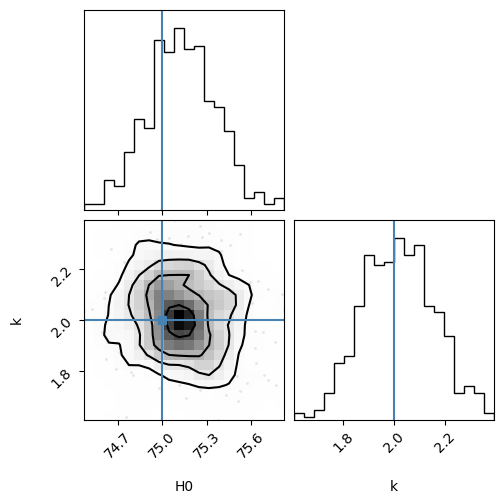

In [28]:
fig = corner(X, truths=truths, labels=keys,smooth=1)
fig.savefig("/Users/rstiskalek/Downloads/corner_H0_k.png", dpi=450)
fig.show()